# 2D circle perimeter estimation using neural network
This is a simple notebook to demonstrate basic principles of neural network design and traning with highly imbalanced training data. 

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import matthews_corrcoef

## Get input data and define the training target

In [2]:
def get_input_data(n_pts):
    """
    Get random numbers in the [-1, 1] range and return those in 
    array that has n_pts rows and 2 columns. 
    """
    data = np.random.rand(n_pts, 2) * 2 - 1
    return data
    
def calculate_target(input_data): 
    """
    The target is a circle with radius 0.7 centered at (0, 0).
    Target is 1 when point is in circle perimeter within small tolerance. 
    Elsewhere the target is 0.
    """
    tolerance = 0.01
    radius = 0.7
    radius_min = radius - tolerance
    radius_max = radius + tolerance
    
    radiuses = np.sqrt(input_data[:, 0] ** 2 + input_data[:, 1] ** 2)
    targets = []
    for radius in radiuses:
        if radius > radius_min and radius < radius_max:
            targets.append(1)
        else:
            targets.append(0)
    return np.array(targets)
    
    
input_data = get_input_data(n_pts=20000)
target = calculate_target(input_data)

## Visualize the data

In [3]:
def scatter_plot(input_data, data_class, figsize=(14, 11), cmap='PiYG'):
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.set_facecolor((0, 0, 0))
    plt.scatter(input_data[:, 0], input_data[:, 1], c=data_class, alpha=1, s=10, cmap=cmap, vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

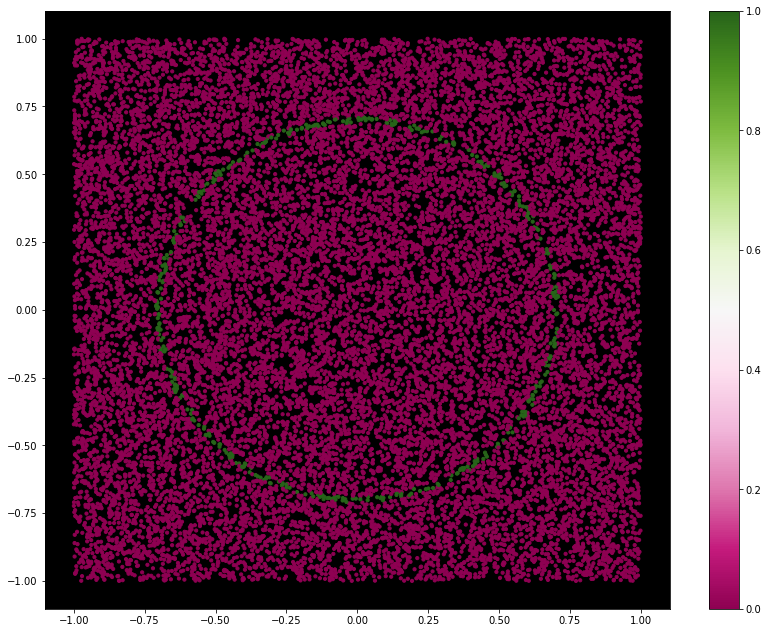

In [4]:
scatter_plot(input_data, target)

## Check class balance

In [5]:
n_neg = np.sum(target == 0)
n_pos = np.sum(target == 1)
print('Class 0 samples : {}'.format(n_neg))
print('Class 1 samples : {}'.format(n_pos))
print('Neg/Pos ratio : {:.2f}'.format(n_neg / n_pos))

Class 0 samples : 19577
Class 1 samples : 423
Neg/Pos ratio : 46.28


# Neural network model 

In [27]:
def get_model():
    inputs = Input(shape=(2,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [28]:
batch_size = 128
epochs = 20
pos_class_weight = 45
neg_class_weight = 1

class_weights = {0 : neg_class_weight, 1: pos_class_weight}
history = model.fit(x=input_data, y=target, batch_size=batch_size, epochs=epochs, 
                    verbose=0, validation_split=0.3, class_weight=class_weights)

## Plot training results

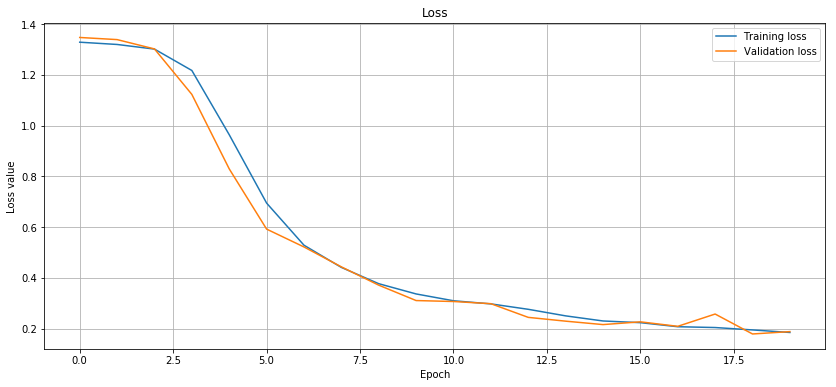

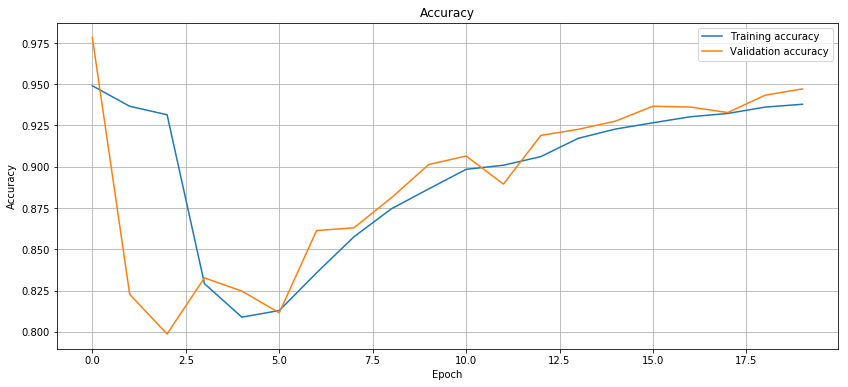

In [29]:
def plot_history(history, figsize=(14, 6)):
    # Loss
    plt.figure(figsize=figsize)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss value')
    plt.legend()
    plt.grid()
    plt.show()

    # Accuracy
    plt.figure(figsize=figsize)
    plt.plot(history.history['acc'], label='Training accuracy')
    plt.plot(history.history['val_acc'], label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()
    
plot_history(history)

## Testing


In [30]:
# Get new data for testing 
test_data = get_input_data(10000)
test_targets = calculate_target(test_data)

# Make predictions using the trained model 
predictions = model.predict(x=test_data, verbose=1, batch_size=128).flatten()

10000/10000 [==============================] - 0s 13us/step


In [47]:
def evaluate_results(predictions, targets):
    """
    Calculate the most basic model performance metrics. 
    """
    class_threshold = 0.5 
    predictions = (predictions > class_threshold) * 1
    metrics = {'true_neg' : 0, 'false_neg' : 0, 'true_pos' : 0, 'false_pos' : 0}
    
    for idx, prediction in enumerate(predictions):
        true = targets[idx]
        if true == 1 and prediction == 1: 
            metrics['true_pos'] += 1
            
        elif true == 0 and prediction == 1: 
            metrics['false_pos'] += 1
        
        elif true == 0 and prediction == 0: 
            metrics['true_neg'] += 1
        
        elif true == 1 and prediction == 0: 
            metrics['false_neg'] += 1

    matthews_corr = matthews_corrcoef(targets, predictions)
    print('Results')
    for key, value in metrics.items():
        print(key,':\t', value)
    print('Matthews correlation : {:.3f}'.format(matthews_corr))
    
evaluate_results(predictions, test_targets)

Results
true_neg :	 9239
false_neg :	 0
true_pos :	 210
false_pos :	 551
Matthews correlation : 0.510


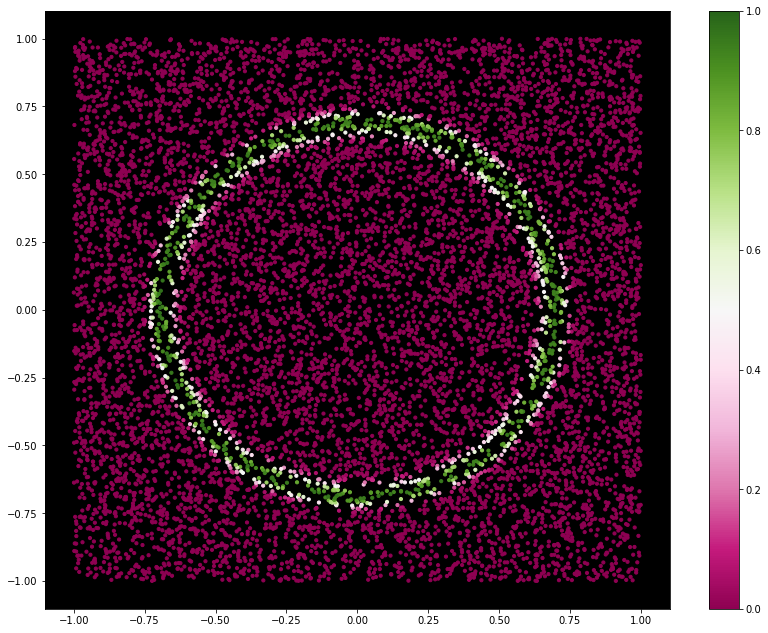

In [33]:
# Plot the prediction results 
scatter_plot(test_data, predictions)

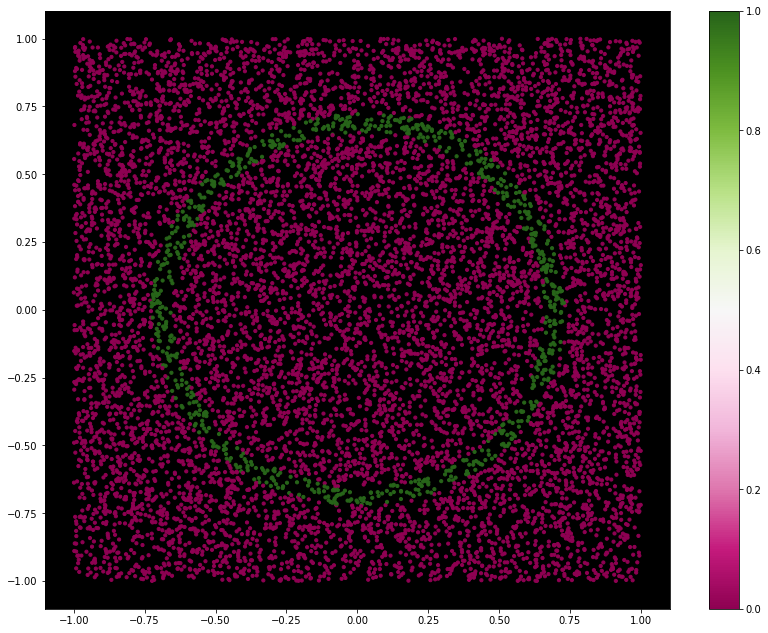

In [34]:
# Make the same plot with binary values using threshold 0.5. 
scatter_plot(test_data, (predictions > 0.5) * 1)